In [1]:
import numpy as np
import cvxpy
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import euclidean
from util_1 import *

#  2.1 Rangement d’objets (optimisation combinatoire)

__1) Comment traduire mathématiquement que la boîte $i$ contient
un objet et un seul et que l’objet $j$ se trouve dans une boîte et une seule ?__

On note $O_{j}\rightarrow B_{i}$ la relation _"l'objet $j$ est dans la boite $i$"_

Alors, 

$$\forall i\enspace \exists!j\enspace / \enspace O_{j}\rightarrow B_{i} \Leftrightarrow \forall i\; \sum_{j}x_{i,j} = 1$$

Et de même, 

$$\forall j\enspace \exists!i\enspace / \enspace O_{j}\rightarrow B_{i} \Leftrightarrow \forall j\; \sum_{i}x_{i,j} = 1$$

__2) Formulation du PLNE et mise en oeuvre de sa résolution__

Le problème de programmation linéaire en nombre entiers s’écrit :

$$ (\mathcal{P}) : \underset{x}{\min}\sum_{i,j}x_{i,j}\|O_{j}-B_{i}\|\quad \text{s.c}\enspace
\begin{matrix}\forall i\; \sum_{j}x_{i,j} = 1\\ 
\forall j\; \sum_{i}x_{i,j} = 1
\end{matrix}
$$

Charger les coordonnées

In [2]:
position_casier = pd.read_table("data/RangerObjets/PositionCasiers.txt")
position_objet = pd.read_table("data/RangerObjets/PositionObjets.txt")

print(position_casier.shape)
print(position_casier.shape)

position_casier.sample(n=3)

(15, 2)
(15, 2)


,x,y
12,0.357143,0
9,0.142857,0
0,-0.500000,0


In [3]:
position_casier = position_casier.values
position_objet = position_objet.values

Calcul de la matrice des distances $\|O_{j}-B_{i}\|$

In [4]:
n = len(position_casier)
distance = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        distance[i,j] = euclidean(position_objet[i], position_casier[j])
distance = distance.flatten()

Formulation du PLNE avec contraintes :

- `X` : mapping objet-casier
- `constraints_i` : contraintes "unique objet par casier"
- `constraints_j` : contraintes "unique casier par objet"
- `total_distance` : fonction distance objectif à minimiser

Visuellement, cela se caractérise par la présence d'une seule valeur 1 sur chaque ligne/colonne de `X`

In [5]:
X = cvxpy.Variable((n,n), boolean=True)
constraints_i = [X[i,:]*np.ones(n) == 1 for i in range(n)]
constraints_j = [X[:,j]*np.ones(n) == 1 for j in range(n)]
constraints = constraints_i + constraints_j

total_distance = X.flatten() * distance

In [6]:
objet_casier_pb = cvxpy.Problem(cvxpy.Minimize(total_distance), constraints)

Résolution du problème : on opte pour `ECOS_BB`, un solver de type "branch-and-bound" adapté aux problème de type mixed-integer

In [7]:
distance_opt = objet_casier_pb.solve(solver=cvxpy.ECOS_BB)
print("Distance optimale : ", round(distance_opt, 4))

Distance optimale :  15.3776


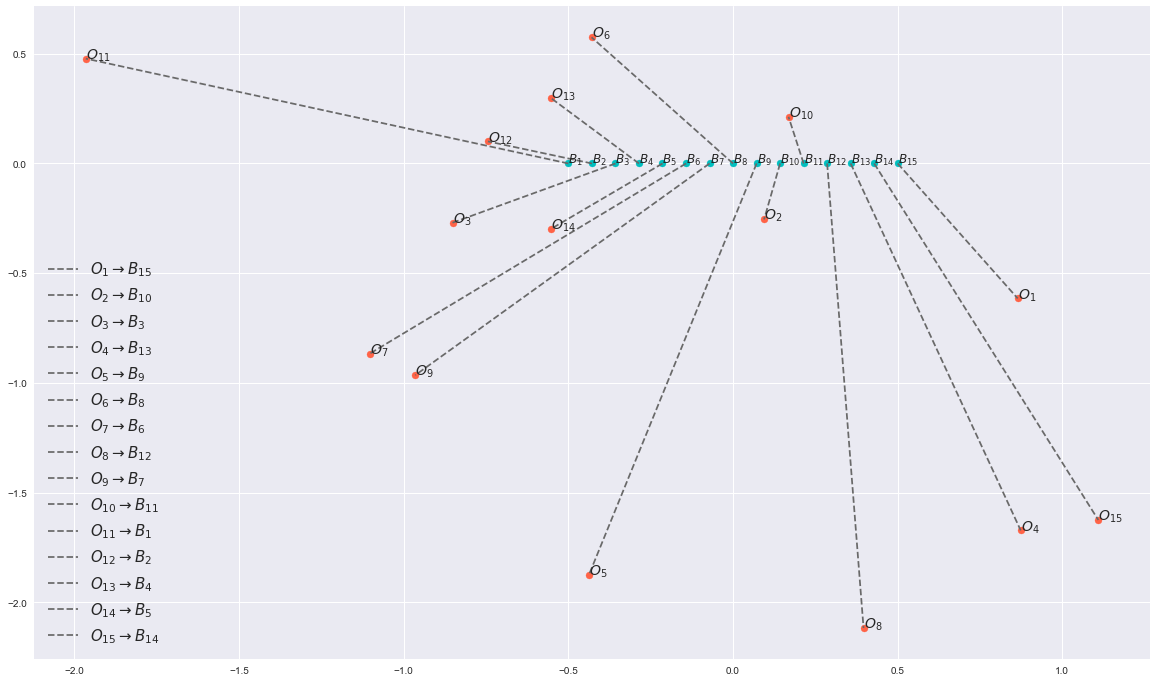

In [8]:
X_value = mat_to_mapping(X.value)
plot_objet_casier(position_objet, position_casier, X_value)

__3) Objet n°1 à gauche directe de l'Objet n˚2__

On formule cette nouvelle contrainte par :

$$\forall i\in [\![2,n-1]\!] \enspace x_{i,1}-x_{i+1,2} = 0$$

De plus, cette contrainte impose également que la relation $O_{1}\rightarrow B_{n}$ est impossible car $O_{2}$ ne peut alors être droite de $O_{1}$. 

On impose donc $x_{n,1}=0$ (il s'ensuit par les contraintes précédentes que $x_{1,2}=0$) 

In [137]:
contrainte_objet_1_2 = [X[i,0]==X[i+1,1] for i in range(n-1)] + [X[14,0]==0]

In [138]:
constraints_new_1_2 = constraints + contrainte_objet_1_2

In [139]:
objet_casier_pb = cvxpy.Problem(cvxpy.Minimize(total_distance), constraints_new_1_2)

distance_opt = objet_casier_pb.solve(solver=cvxpy.ECOS_BB)
print("Distance optimale : ", round(distance_opt, 4))

Distance optimale :  15.5651


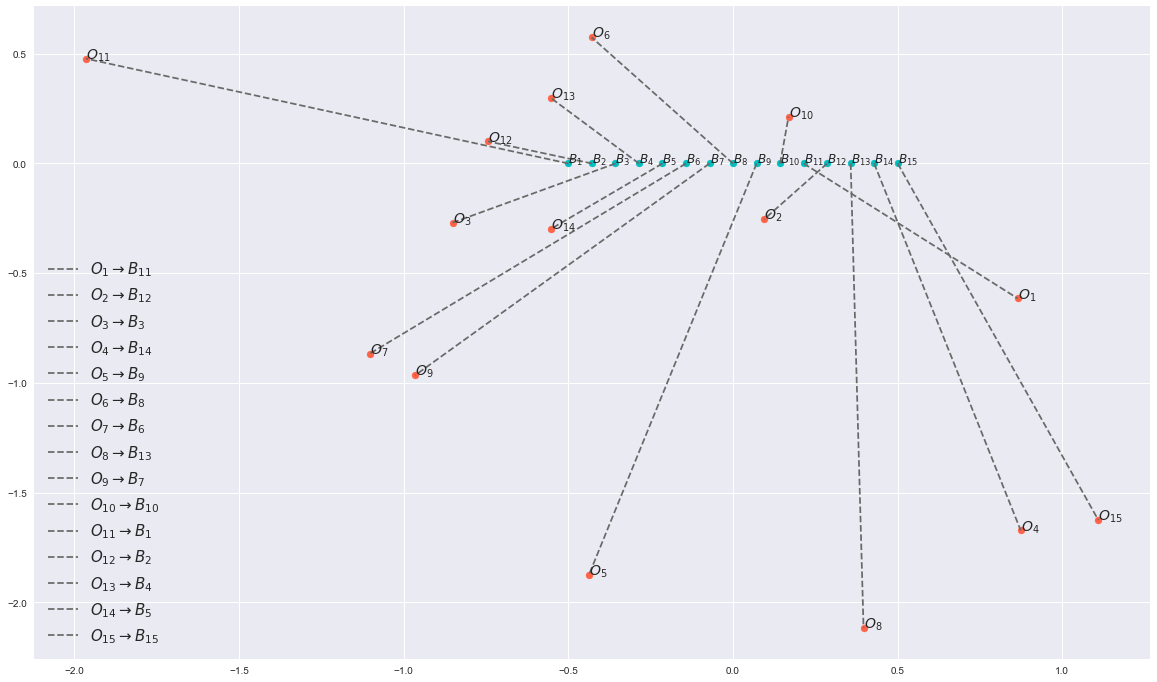

In [140]:
X_value = mat_to_mapping(X.value)
plot_objet_casier(position_objet, position_casier, X_value)

__4) Objet n°3 à droite de l'Objet n˚4__

Montrons que $x_{i,3}+x_{i+k,4}\leq 1,\;\forall i,\;\forall k>0 \Leftrightarrow O_{3}$ à droite de $O_{4}$

$(\Rightarrow)$
> Raisonnons par l'absurde et supposons $O_{3}$ à gauche de $O_{4}$

> Notons $i_{3}$ l'indice de la boite contenant $O_{3}$. 
> Alors, la boite contenant $O_{4}$ étant à droite de $B_{i_{3}}$, $\exists k>0 \enspace / O_{4}\rightarrow B_{i_{3}+k}$

> $\Rightarrow x_{i_{3},3} = 1$ et $x_{i_{3}+k,4}=1$

> $\Rightarrow x_{i_{3},3} + x_{i_{3}+k,4} > 1$ ce qui est impossible

$(\Leftarrow)$

> Notons $i_{3}$ l'indice de la boite contenant $O_{3}$

> Comme $O_{4}$ à gauche de $O_{3}$, $\forall k>0, \; x_{i_{3}+k,4}=0$

> $\Rightarrow x_{i_{3},3} + x_{i_{3}+k,4} \leq 1$

On remarque que cette contrainte peut se réécrire de façon plus succinte selon :

$$ \forall i\in[\![1,n-1]\!], \; x_{i,3} + \sum_{k=i+1}^{n}x_{k,4} \leq 1$$

En effet, pour un $i$ donné, si $O_{3}\rightarrow B_{i}$ et que $O_{3}$ à droite de $O_{4}$, alors toutes les boites d'indice supérieur ne peuvent contenir $O_{4}$, c'est à dire $\forall k\in[\![i+1,n]\!], \; x_{k,4}=0$.

Cette contrainte englobe également les cas limite :

- Si $i=1$, $O_{4}$ ne peut être dans $B_{1}$ aussi selon les contraintes précédentes et la nouvelle contrainte lui interdit d'être à droite de $O_{3}$, c'est donc un cas impossible

- So $i=n$, $O_{4}$ ne peut être dans $B_{n}$ aussi selon les contraintes précédentes et est donc nécessairement à gauche de $O_{3}$

In [149]:
constraints_objet_3_4 = []
constraints_objet_3_4 = [X[i,2] + cvxpy.sum(X[i+1:,3]) <= 1 for i in range(n-1)]

In [150]:
constraints_new_3_4 = constraints_new_1_2 + constraints_objet_3_4

In [153]:
objet_casier_pb = cvxpy.Problem(cvxpy.Minimize(total_distance), constraints_new_3_4)
distance_opt = objet_casier_pb.solve(solver=cvxpy.ECOS_BB)

print("Distance optimale : ", round(distance_opt, 4))

Distance optimale :  16.2044


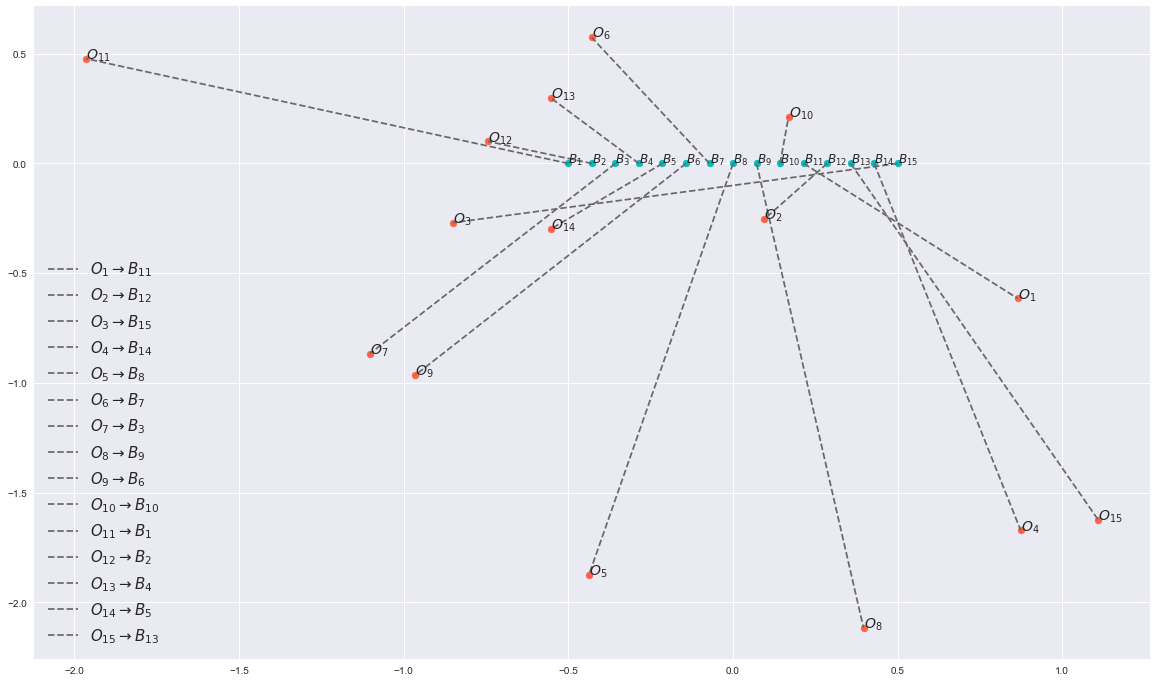

In [152]:
X_value = mat_to_mapping(X.value)
plot_objet_casier(position_objet, position_casier, X_value)

__5) Objet n°7 à côté de l'Objet n˚9__

Il suffit ici de symétriser la contrainte énoncée à la question 3 pour autoriser d'être à droite ou à gauche

$$\forall i\in [\![1,n-1]\!] \enspace x_{i,7}-x_{i+1,9} = 0 \quad\text{ou}\quad x_{i+1,7}-x_{i,9} = 0 $$

$$\Rightarrow \forall i\in [\![1,n-1]\!] \enspace (x_{i,7}-x_{i+1,9})(x_{i+1,7}-x_{i,9}) = 0 $$

Le problème d'optimisation n'est alors plus linéaire.

Une façon de contourner ce problème consiste à résoudre le problème en imposant $O_{7}$ à gauche de $O_{9}$, puis celui imposant $O_{7}$ à droite de $O_{9}$, et de garder la solution minimisant la distance totale

In [154]:
contrainte_objet_7_9_droite = [X[i,6]==X[i+1,8] for i in range(n-1)]
contrainte_objet_7_9_gauche = [X[i,8]==X[i+1,6] for i in range(n-1)]

In [155]:
constraints_new_7_9_droite = constraints_new_3_4 + contrainte_objet_7_9_droite
constraints_new_7_9_gauche = constraints_new_3_4 + contrainte_objet_7_9_gauche

In [157]:
objet_casier_pb_droite = cvxpy.Problem(cvxpy.Minimize(total_distance), constraints_new_7_9_droite)
distance_droite = objet_casier_pb_droite.solve(solver=cvxpy.ECOS_BB)

objet_casier_pb_gauche = cvxpy.Problem(cvxpy.Minimize(total_distance), constraints_new_7_9_gauche)
distance_gauche = objet_casier_pb_gauche.solve(solver=cvxpy.ECOS_BB)

print("Distance droite : ", round(distance_droite, 4))
print("Distance gauche : ", round(distance_gauche, 4))

Distance droite :  15.9048
Distance gauche :  15.9118


On conserve donc le cas où $O_{7}$ juste à droite de de $O_{9}$

In [159]:
objet_casier_pb = cvxpy.Problem(cvxpy.Minimize(total_distance), constraints_new_7_9_droite)
distance_opt = objet_casier_pb.solve(solver=cvxpy.ECOS_BB)

In [160]:
print("Distance optimale : ", round(distance_opt, 4))

Distance optimale :  15.9048


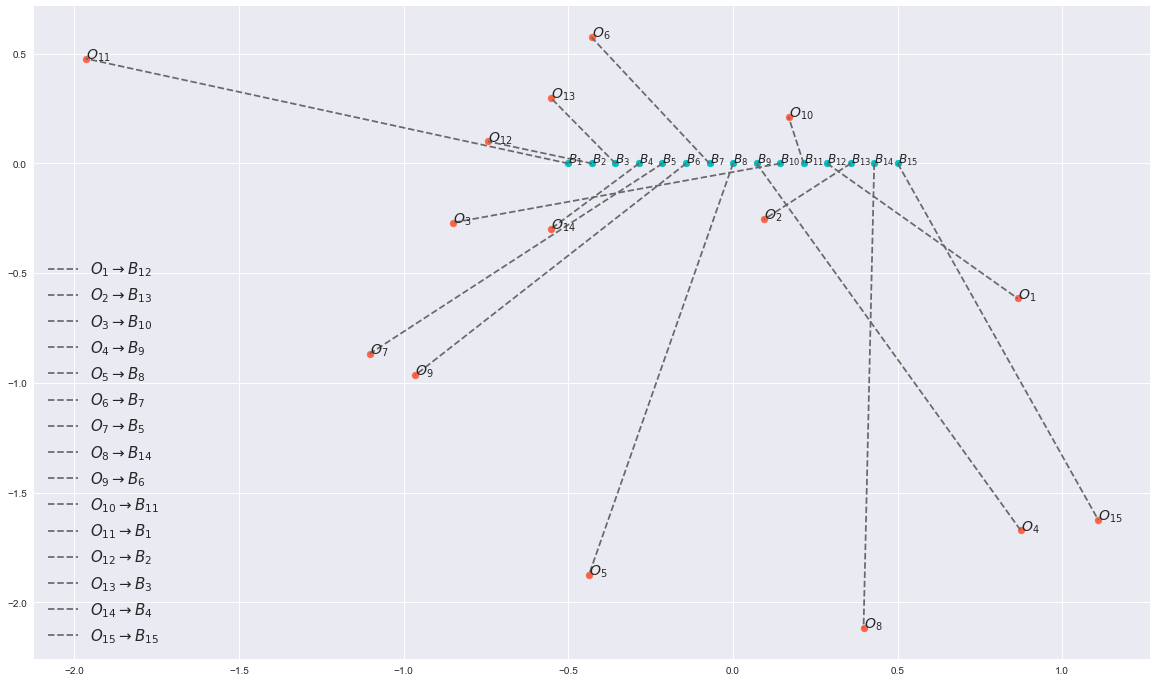

In [161]:
X_value = mat_to_mapping(X.value)
plot_objet_casier(position_objet, position_casier, X_value)

__6) Unicité de la solution__

On remarque que les objets 13 et 14 sont symétriques par rapport à l'axe des abscisses. Donc en principe, échanger leurs attributions mutuelles ne devrait pas impacter la distance

In [169]:
print("Objet 13 : ", position_objet[12])
print("Objet 14 : ", position_objet[13])

Objet 13 :  [-0.552307  0.297433]
Objet 14 :  [-0.552307 -0.297433]


On impose donc la contrainte $x_{4,13}=1$

In [170]:
unicity_test_constraint = [X[3,12]==1]
constraints_new_unicity_test = constraints_new_7_9_droite + unicity_test_constraint

In [171]:
objet_casier_pb = cvxpy.Problem(cvxpy.Minimize(total_distance), constraints_new_unicity_test)
distance_opt = objet_casier_pb.solve(solver=cvxpy.ECOS_BB)

print("Distance optimale : ", round(distance_opt, 4))

Distance optimale :  15.9048


La distance optimale étant identique, on prouve qu'il n'y a pas unicité de la solution